TODO: Small description for notebook

## <span style="color:black">Mount drive to notebook</span>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## <span style="color:black">Install needed packages</span>

In [ ]:
!pip install tld
!pip install pandas==1.0.5

import os
import bz2
import json
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from utils import process_chunk, process_text, manual_extraction, ids_to_tweets

#Packages for url parsing
import tld
from tld import get_tld
from urllib.request import urlopen
from bs4 import BeautifulSoup
#Packages for NLP methods
import re
import nltk
import gensim
from gensim import models
from gensim import corpora
import gensim.downloader as api
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
# We need this dataset in order to use the tokenizer
nltk.download('punkt')
# Also download the list of stopwords to filter out
nltk.download('stopwords')
stemmer = PorterStemmer()

# Add constants/paths
_DATASETS_PATHS = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## <span style="color:Blue">1) Load Datasets</span>

In [ ]:
# Save the datasets paths
quote_datasets = sorted(glob.glob(_DATASETS_PATHS+'/Quotebank/*.bz2'))
quote_datasets

['/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2015.json.bz2',
 '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2016.json.bz2',
 '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2017.json.bz2',
 '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2018.json.bz2',
 '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2019.json.bz2',
 '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2020.json.bz2']

### <span style="color:red"><div style="text-align: justify">In order to deal with extremely large data we decided chunking the data and apply all the processing and data wrangling steps on chunks then combine the chunk results (inspired by this [article](https://towardsdatascience.com/3-simple-ways-to-handle-large-data-with-pandas-d9164a3c02c1))</div></span>

In [ ]:
#Iterate through years dataset then create an iterator to process chunks of 1M rows at a time
num_quotes_per_year = {}
for dataset in quote_datasets:
    data_name = os.path.basename(dataset).split('-')[1]
    num_quotes_per_year[data_name] = 0
    df_reader = pd.read_json(dataset, lines=True, compression='bz2', chunksize=500000)
    print('Processing Data:', data_name)
    for chunk in df_reader:
        num_quotes_per_year[data_name] += len(chunk)
    print(f'About {num_quotes_per_year[data_name]} in {data_name}')

In [ ]:
dataset = {'year': [i.split('.')[0]for i in list(num_quotes_per_year.keys())],
           'num_quotes': list(num_quotes_per_year.values())}
df = pd.DataFrame(dataset)
df

,year,num_quotes
0,2015,20874338
1,2016,13862129
2,2017,26611588
3,2018,27228451
4,2019,21763302
5,2020,5244449


Text(0, 0.5, '# of Quotes')

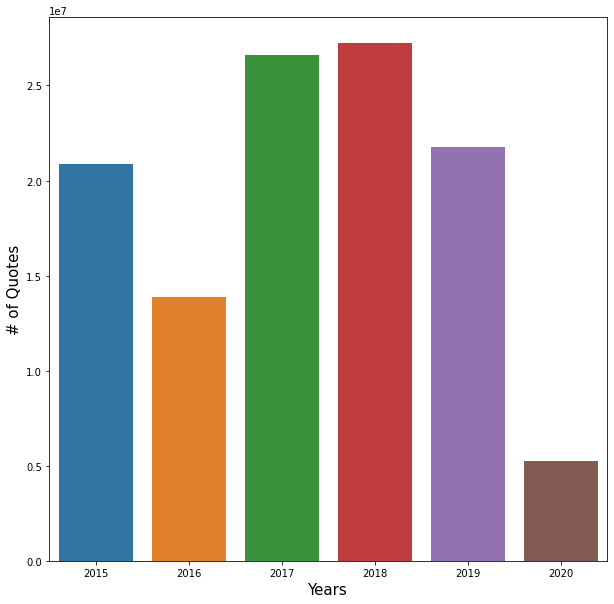

In [ ]:
#Visualize number of quotes per year
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax = sns.barplot(x="year", y="num_quotes", data=df, capsize=.5, ax=axis)
ax.set_xlabel('Years', fontsize=15)
ax.set_ylabel('# of Quotes', fontsize=15)

## <span style="color:Blue">2) Topic Analysis</span>

### <span style="color:Red"><div style="text-align: justify">After loading the data, we need to extract the targeted quotes from the dataset that will be used in our project. Thus, there are three methods to do so explained below.</div></span>

### <span style="color:green">A- Manual Extraction Method</span>

#### <span style="color:purple"><div style="text-align: justify">This method is a naive one which means extracting the rows that their quotes include specific keywords. Accordingly, in order to compile a more thorough keywords, we investigated a couple of articles/papers concerning sexual harassement movements such as MeToo such as: [article 1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6751092/)</div></span>

#### <span style="color:purple"><div style="text-align: justify"> Then, we decided to filter the dataset from 2015-2020 with one keyword (metoo) and from the resulted quotes we built a word cloud using [WordCloud Library](https://amueller.github.io/word_cloud/) to select the top 20 keywords mentioned in these quotes and pick the relevant ones. Also, we added keywords from this [website](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/2SRSKJ) and this [article](https://journals.sagepub.com/doi/10.1177/1940161220968081) to end up at the end with 15 keywords.</div></span>

In [ ]:
#Iterate through all datasets and extract the quotes containing metoo
for dataset in quote_datasets:
    df_reader = pd.read_json(dataset, lines=True, compression='bz2', chunksize=500000)
    print('Processing Data:', os.path.basename(dataset))
    for chunk in df_reader:
        chunk = process_chunk(chunk, manual_extraction, keywords_quotes_path)

#### <span style="color:purple"><div style="text-align: justify"> The results of the above cell is saved in the path mentioned below.</div></span>

In [ ]:
me_too_quotes_path = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/metoo-extracted-quotes.csv.bz2'

In [ ]:
#Load the saved results from previous cell
warnings.simplefilter(action='ignore', category=FutureWarning)
df = pd.read_csv(me_too_quotes_path)
df.drop(df[df == 'quotation'].index)
df = df.drop(columns='Unnamed: 0')
print(f'The number of quotes that contain metoo: {len(df)}')
df.head(10)

The number of quotes that contain metoo: 1270


,quotation
0,This important study will help Eabametoong Fir...
1,The real #metoo video is finally up! Missed th...
2,Might have fell down... but I KILLLED that shI...
3,The real #metoo video is finally up! Missed th...
4,The real #metoo is finally up! Missed that bas...
5,The real #metoo video is finally up!
6,Might have fell down... but I KILLLED that [ e...
7,We're shocked by @stassi's comments re the #me...
8,"The #metoo movement is growing daily, as high-..."
9,When people like me are wrongfully accused by ...


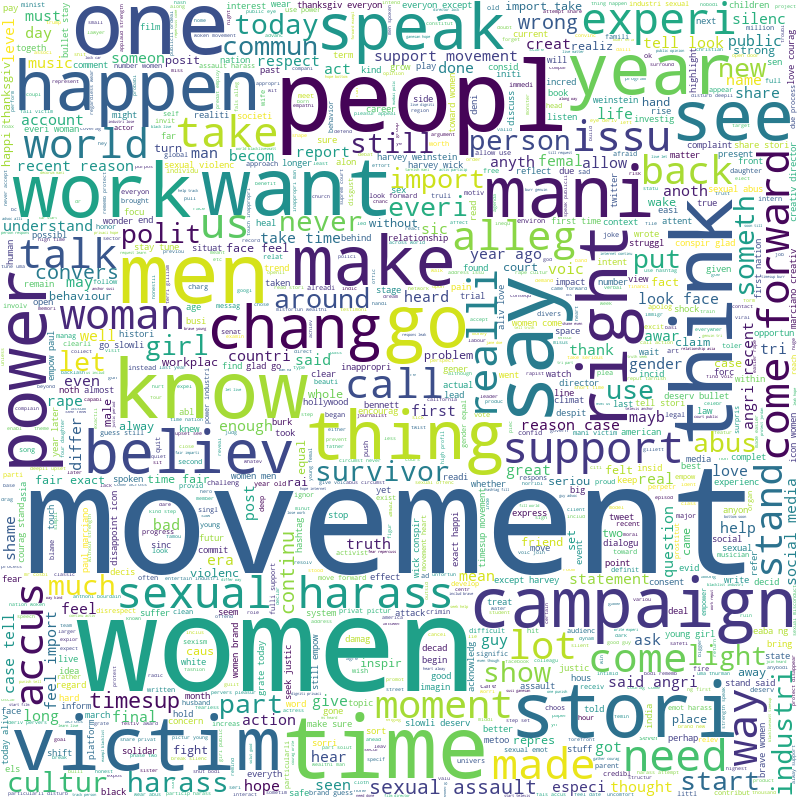

In [ ]:
#Create a word cloud from the extracted quotes
df = df.quotation.str.replace('metoo', ' ')
#Process texts in quotes
cleaned_text = df.apply(process_text)
#Join the different processed titles together.
long_string = ','.join([text for text_list in cleaned_text.values for text in text_list])
#Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 800, background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
#Generate a word cloud
wordcloud.generate(long_string)
#Visualize the word cloud
wordcloud.to_image()

In [ ]:
#Filter the top words from word cloud using an arbitrarily threshold then sort them
filtered_words = dict()
#Iterate over all the items in dictionary
for (key, value) in wordcloud.words_.items():
    #Check if item satisfies the given condition then add to new dict
    #Set an arbitrarily value to shorten the list
    if value >= 0.15:
        filtered_words[key] = value
sorted_words = dict(sorted(filtered_words.items(), key=lambda kv: kv[1], reverse=True))

Text(0, 0.5, 'Mentions Ratio')

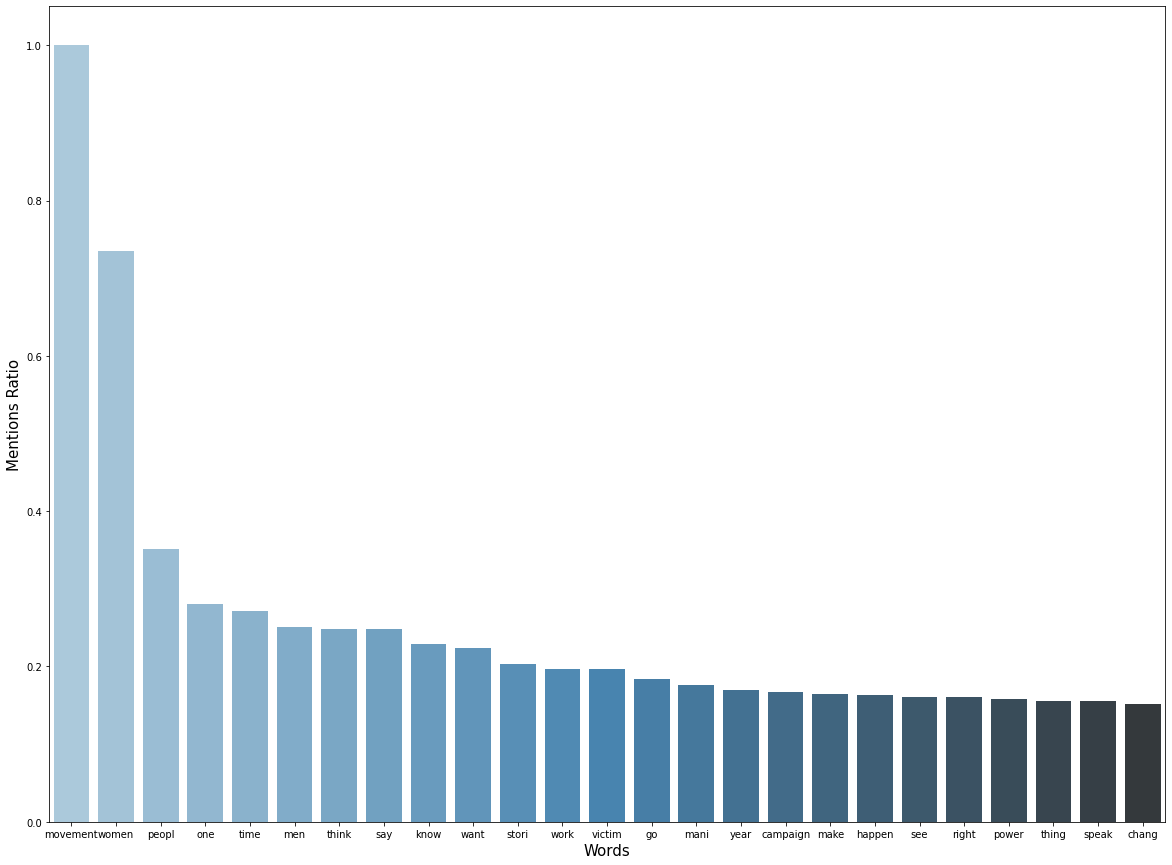

In [ ]:
#Visualize the mentions of the words generated from word cloud
words = pd.DataFrame({'words': list(sorted_words.keys()), 'mentions ratio': list(sorted_words.values())})
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(20,15))
ax = sns.barplot(x="words", y="mentions ratio", data=words, capsize=.5, ax=axis, palette="Blues_d")
ax.set_xlabel('Words', fontsize=15)
ax.set_ylabel('Mentions Ratio', fontsize=15)
#Modify xticks size

In [ ]:
#The final keywords compiled
keywords = ['movement', 'women', 'victim', 'campaign', 'sex', 'harass', 'assualt',
           'rape', 'misconduct', 'metoo', 'timesup', 'abuse', 'workplace', 'right', 'femin']
#Save the results from keywords extraction in this path
keywords_quotes_path = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/keywords-extracted-data.csv.bz2'

In [ ]:
#Iterate through all datasets and extract the quotes containing any of the keywords selected
for dataset in quote_datasets:
    df_reader = pd.read_json(dataset, lines=True, compression='bz2', chunksize=500000)
    print('Processing Data:', os.path.basename(dataset))
    for chunk in df_reader:
        chunk = process_chunk(chunk, manual_extraction, keywords, keywords_quotes_path)

Processing Data: quotes-2015.json.bz2
Processing chunk with 500000 rows
There are 27052 rows that include some of the keywords
Processing chunk with 500000 rows
There are 27247 rows that include some of the keywords
Processing chunk with 500000 rows
There are 27124 rows that include some of the keywords
Processing chunk with 500000 rows
There are 27034 rows that include some of the keywords
Processing chunk with 500000 rows
There are 26961 rows that include some of the keywords
Processing chunk with 500000 rows
There are 27092 rows that include some of the keywords
Processing chunk with 500000 rows
There are 27088 rows that include some of the keywords
Processing chunk with 500000 rows
There are 27054 rows that include some of the keywords
Processing chunk with 500000 rows
There are 26980 rows that include some of the keywords
Processing chunk with 500000 rows
There are 27124 rows that include some of the keywords
Processing chunk with 500000 rows
There are 27160 rows that include some

In [ ]:
#Load the manually extracted data based on keywords
df = pd.read_csv(keywords_quotes_path, compression='bz2')
df = df.drop(df[df['quotation'] == 'quotation'].index)
df = df.drop(columns='Unnamed: 0')
print(f'The number of quotes that contain some of the selected keywords: {len(df)}')
df.head(10)

The number of quotes that contain some of the selected keywords: 6625708


,quoteID,quotation,speaker,qids,date,probas,urls
0,2015-08-31-000271,... a great day for veterans here in Littleton...,Jeanne Shaheen,['Q270316'],2015-08-31 02:10:00,"[['Jeanne Shaheen', '0.742'], ['None', '0.2359...",['http://www.unionleader.com/article/20150831/...
1,2015-10-29-035215,how the greatest movement came into being and ...,None,[],2015-10-29 21:25:14,"[['None', '0.5458'], ['Paul Hawken', '0.4542']]",['https://medium.com/enspiral-tales/bioneers-d...
2,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",Bernie Sanders,['Q359442'],2015-10-25 14:12:35,"[['Bernie Sanders', '0.5395'], ['None', '0.312...",['http://examiner.com/article/bernie-sanders-s...
3,2015-10-17-000460,[ This is ] defamation. I'm hitting back. [ Me...,Meghan King Edmonds,['Q20684375'],2015-10-17 13:35:01,"[['Meghan King Edmonds', '0.7414'], ['None', '...",['http://www.inquisitr.com/2500312/vicki-gunva...
4,2015-09-04-030275,I ain't going nowhere. I'm going to be right h...,Letroy Guion,['Q13219370'],2015-09-04 12:36:42,"[['Letroy Guion', '0.7119'], ['None', '0.2804'...",['http://www.channel3000.com/sports/packers/Pa...
5,2015-12-01-033189,"I am confident enough, optimistic enough to sa...",Frank-Walter Steinmeier,['Q76658'],2015-12-01 08:47:00,"[['Frank-Walter Steinmeier', '0.6923'], ['Mr H...",['http://express.co.uk/news/politics/623296/EU...
6,2015-02-03-000382,A careful analysis of the career histories of ...,Lisa Mainiero,['Q53121229'],2015-02-03 17:22:00,"[['Lisa Mainiero', '0.9511'], ['None', '0.0489']]",['http://www.forbes.com/sites/bonniemarcus/201...
7,2015-01-27-023512,I am honored and proud to raise awareness for ...,Joe Haden,['Q733737'],2015-01-27 13:25:00,"[['Joe Haden', '0.5859'], ['None', '0.3302'], ...",['http://www.istockanalyst.com/article/viewart...
8,2015-09-10-001454,"A couple bumps and bruises, but all right.",James Blake,"['Q350362', 'Q53333']",2015-09-10 06:31:35,"[['James Blake', '0.7538'], ['None', '0.2422']...",['http://rss.cnn.com/c/35494/f/676993/s/49bd29...
9,2015-09-23-032351,I am proud that once again I got to fly the So...,President Barack Obama,['Q76'],2015-09-23 06:04:06,"[['President Barack Obama', '0.6547'], ['None'...",['http://www.bdlive.co.za/business/management/...


In [ ]:
#Extract the Year-Month from the date column to plot a timeline of the selected quotes
df['y-m'] = df['date'].apply(lambda x: x[:7])
quotes_timeline = df[['y-m', 'quotation']].groupby(['y-m'], as_index=False)['quotation'].count()
quotes_timeline.head()

,y-m,quotation
0,2015-01,87584
1,2015-02,88268
2,2015-03,102218
3,2015-04,83233
4,2015-05,62275


Text(0, 0.5, '# of Quotes')

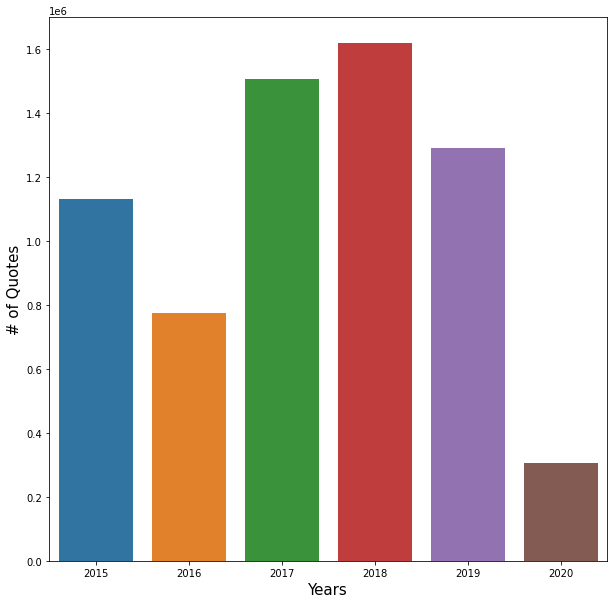

In [ ]:
#Visualize number of quotes per year
quotes_timeline['year'] = quotes_timeline.index
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax = sns.barplot(x="year", y="quotation", data=quotes_timeline, capsize=.5, ax=axis)
ax.set_xlabel('Years', fontsize=15)
ax.set_ylabel('# of Quotes', fontsize=15)

In [ ]:
#Compare the barplots of unfiltered vs filtered quotes

#### <span style="color:purple"><div style="text-align: justify"> The final results of the *Manual Extraction Step* is manifested in the timeline plotted below of the number of extracted quotes across time.</div></span>

Text(0, 0.5, '# of Quotations')

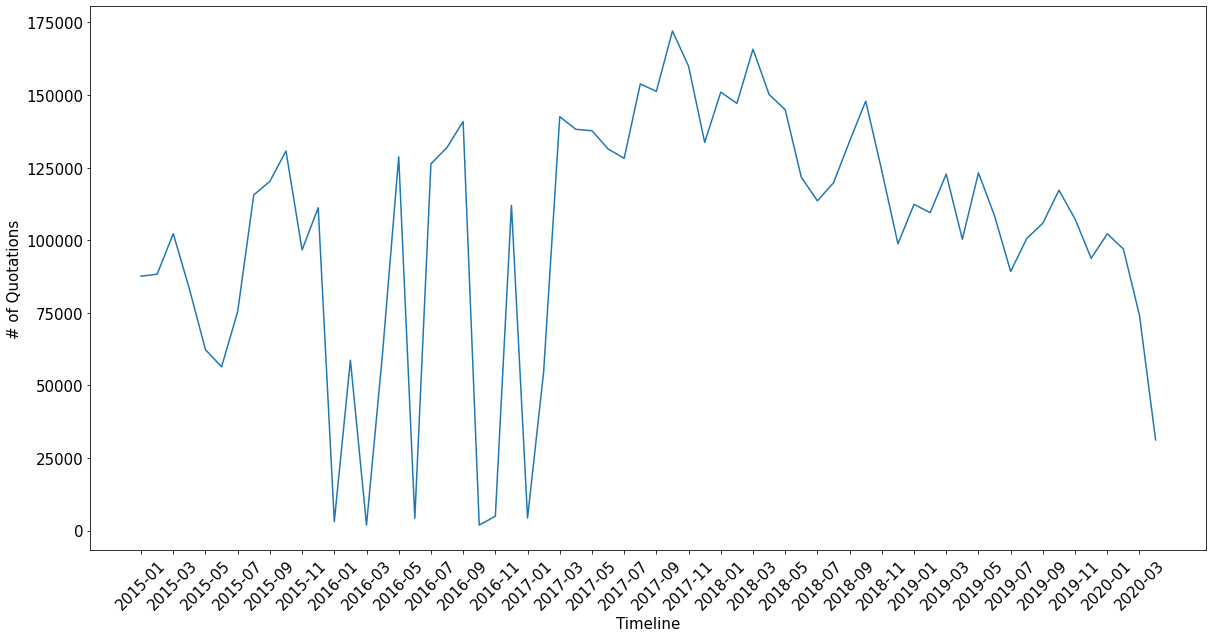

In [ ]:
#Visualizing the number of quotes throughout time
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = sns.lineplot(x='y-m', y='quotation', data=quotes_timeline, ax=axis)
ax.set_xticks(quotes_timeline['y-m'][::2])
ax.set_xticklabels(quotes_timeline['y-m'][::2], rotation=45)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Timeline', fontsize=15)
ax.set_ylabel('# of Quotations', fontsize=15)

#### <span style="color:purple"><div style="text-align: justify"> To account for the variation of quotes across the days of each month. We plotted the mean of quotes in each month in addition to showing the 95% confidence interval</div></span>

In [ ]:
#Extract the day from the date column
df['day'] = df['date'].apply(lambda x: x[8:10])
quotes_timeline = df[['y-m', 'day', 'quotation']].groupby(['y-m','day'], as_index=False)['quotation'].count()
quotes_timeline.head()

,y-m,day,quotation
0,2015-01,01,1312
1,2015-01,02,1924
2,2015-01,03,1319
3,2015-01,04,1382
4,2015-01,05,2501


Text(0, 0.5, '# of Quotations')

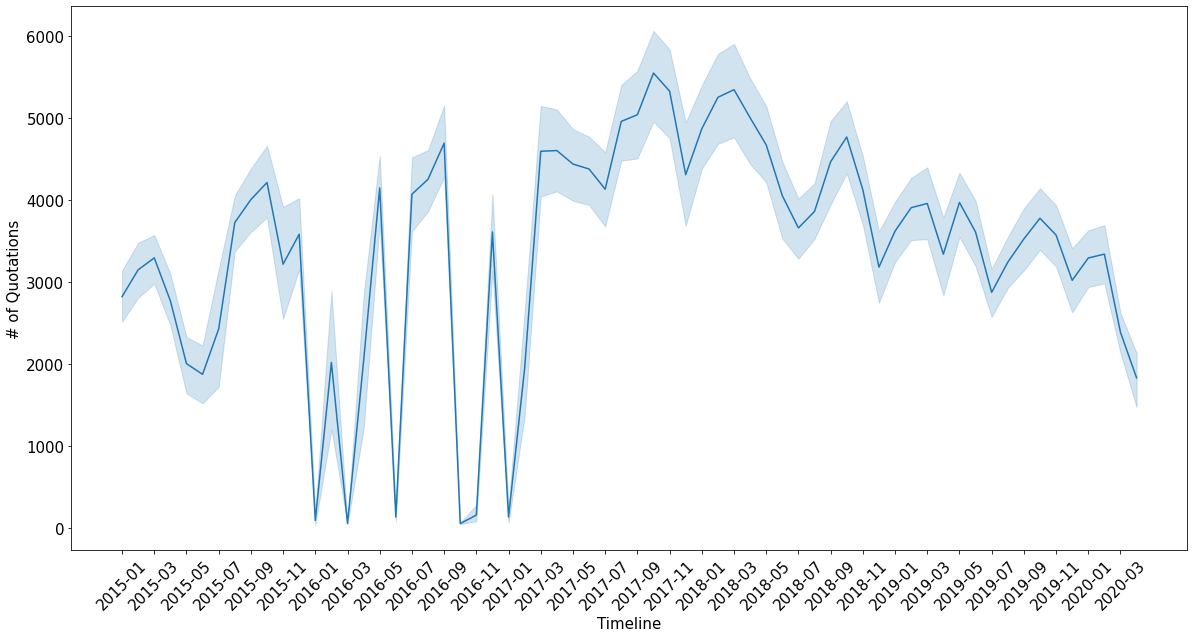

In [ ]:
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = sns.lineplot(x='y-m', y='quotation', data=quotes_timeline, ax=axis)
ax.set_xticks(np.sort(df['y-m'].unique())[::2])
ax.set_xticklabels(np.sort(df['y-m'].unique())[::2], rotation=45)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Timeline', fontsize=15)
ax.set_ylabel('# of Quotations', fontsize=15)

---

### <span style="color:green">B- Parsing URLs Method</span>

#### <span style="color:purple"><div style="text-align: justify">This method would help filter quotes based on the article title which would be extracted from the urls. First, we will extract the hostnames of the urls. Then, pick the top 20 hostnames in terms of occurences and extract their titles to hand-pick the relevent titles.</div></span>

'environment-and-nature'

Add Plots and mention limitations for this method

---

### <span style="color:green">C- NLP-based Method</span>

#### <span style="color:purple"><div style="text-align: justify">The quotes extracted so far could some of them still not be related to *Sexual Harassment* (as shown below for an example). Hence, in this step, we will explore different NLP-based methods to properly perform *Topic Modeling* and only save the related quotes to our project</div></span>

#### <span style="color:purple"><div style="text-align: justify">Below are the methods explored, the reason why we used them and sample of the results. But first let's apply some basic NLP preprocessing to prepare the quotes, including:</div></span>

##### <span style="color:orange">
- Tokenization using *NLTK*.
- Removing *Stop Words*
- Removing *Punctuation Symbols*
- Stemming words to their roots
</span>

#### <span style="color:purple"><div style="text-align: justify">After applying preprocessing on the manually extracted quotes, save the new format *(List of words)* in a pickle file.</div></span>

In [ ]:
#Read the extracted quotes as chunck of 0.5M to preprocess them
quotes_list = []
save_pickle_file = _DATASETS_PATHS+'/lists_of_words.pkl'
df_reader = pd.read_csv(keywords_quotes_path, compression='bz2', chunksize=500000)
print('Processing Data:', os.path.basename(dataset))
for chunk in df_reader:
  #Open pickle file in append mode
  with open(save_pickle_file, 'ab') as f:
    chunk = chunk.drop(chunk[chunk == 'quotation'].index)
    chunk = chunk.drop(columns='Unnamed: 0')
    pickle.dump(process_chunk(chunk), f)

Processing Data: keywords-extracted-quotes.csv.bz2


/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 125941 rows
Index(['quotation'], dtype='object')


In [ ]:
#Load the saved pickle file
list_words = list(pd.read_pickle(save_pickle_file))

In [ ]:
#Sample
list_words[10]

['confid',
 'enough',
 'optimist',
 'enough',
 'say',
 'find',
 'right',
 'path',
 'even',
 'want',
 'conceiv',
 'european',
 'union',
 'without',
 'great',
 'britain']

#### <span style="color:magenta">1- LDA *(Latent Dirichlet Allocation)*</span>

In [ ]:
dictionary = corpora.Dictionary(list_words)
corpus = [dictionary.doc2bow(word) for word in list_words]
model = models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

In [ ]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model")
model.save(temp_file)

In [22]:
from gensim.test.utils import common_texts
# Create a corpus from a list of texts
common_dictionary = corpora.Dictionary(common_texts)
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]
# Train the model on the corpus.
lda = models.ldamodel.LdaModel(common_corpus, num_topics=10)

In [ ]:
topics = model.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.069*"right" + 0.023*"go" + 0.021*"get" + 0.018*"think"')
(1, '0.024*"right" + 0.020*"victim" + 0.013*"sex" + 0.012*"sexual"')
(2, '0.034*"right" + 0.011*"need" + 0.010*"work" + 0.008*"make"')
(3, '0.055*"women" + 0.012*"men" + 0.009*"like" + 0.008*"live"')
(4, '0.035*"campaign" + 0.009*"state" + 0.009*"countri" + 0.009*"peopl"')


#### <span style="color:magenta">2- Word2Vec Model</span>

In [32]:
model = models.Word2Vec(list_words, min_count=1,size= 100,workers=3, window =3, sg = 1)

In [34]:
model.most_similar('woman', topn=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('man', 0.7965893745422363),
 ('ladi', 0.7331275939941406),
 ('women', 0.7327994108200073),
 ('person', 0.7210705280303955),
 ('mistress', 0.6907999515533447)]

#### <span style="color:magenta">3- GloVe Model</span>

In [ ]:
word_vectors = api.load('glove-wiki-gigaword-300')
embeddedDF['scentences'] = embeddedDF['scentences'].apply(embedSentence)
#Will be useful later for combining dataframes
keepIndices = embeddedDF.index
embeddedDF['scentences'] = embeddedDF['scentences'].apply(averageEmbedding)

In [ ]:
embeddedDF.index = list(range(0, len(embeddedDF)))
embeddedDF.head()

,scentences
0,"[-0.026508026, 0.03706931, 0.006902222, -0.178..."
1,"[0.057423335, 0.053511336, -0.12297001, -0.084..."
2,"[-0.12058276, -0.00594178, 0.024895065, -0.061..."
3,"[0.16207139, -0.109700255, -0.23056835, -0.235..."
4,"[0.042109244, -0.16742308, -0.053067572, -0.14..."


In [ ]:
FeatureColumns = []
for i in range(0, 300):
    FeatureColumns.append('e'+str(i))
FeatureDF = pd.DataFrame(columns = FeatureColumns)
FeatureDF

,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20,e21,e22,e23,e24,e25,e26,e27,e28,e29,e30,e31,e32,e33,e34,e35,e36,e37,e38,e39,...,e260,e261,e262,e263,e264,e265,e266,e267,e268,e269,e270,e271,e272,e273,e274,e275,e276,e277,e278,e279,e280,e281,e282,e283,e284,e285,e286,e287,e288,e289,e290,e291,e292,e293,e294,e295,e296,e297,e298,e299


---

## <span style="color:Blue">3) Dataset Augmentation</span>

### <span style="color:Red"><div style="text-align: justify">Here, we enrich our dataset with external ones, so we explore each external dataset and apply preliminary analysis on them.</div></span>

### <span style="color:green">A- Twitter Dataset</span>

#### <span style="color:Purple"><div style="text-align: justify">The tweets dataset is acquired from [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/2SRSKJ) which contains 32,071,469 *#metoo* tweets ranging from October 15, 2017 to March 31, 2020. The dataset only contains tweet IDs, thus, we applied for access to Twitter API in order to fetch tweets and their metadata from IDs. The dataset is distributed in 33 txt files *(each containing 1M tweet IDs)*.</div></span>

In [ ]:
#Tweet IDs paths
tweet_ids_paths = sorted(glob.glob(_DATASETS_PATHS+'/me_too_tweets/*.txt'))
print(f' There are {len(tweet_ids_paths)} files of tweet IDs')

 There are 33 files of tweet IDs


In [ ]:
#Twitter Developer keys here
#It is CENSORED
consumer_key = 'NTzTHBeXmtuLiurddtRhyvA5x'
consumer_key_secret = 'o4AhlY4tnTg4heGFSkttAa2w5CIiHhXaerckfu0sIaLAXpPEvm'
access_token = '1456399642103517184-N6FBPIuzHvj5AjUBiIaFDqlcP6kWc6'
access_token_secret = 'kOoQy5iyBd2I7ZIlo4ntPtex9lDps8KVTlvRDl3fyhHs7'

#Get access to the Twitter API to fetch tweets
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [ ]:
#Fetching the needed info from the api (Tweet, Location and Date)
tweets_data = ids_to_tweets('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/me_too_tweets/metoo_project_full_dataset_01.txt', api)

#### <span style="color:Purple"><div style="text-align: justify">We found that some of the IDs are not valid (user suspended/tweet deleted). Accordingly, we fetched the valid ones and saved their infos in a CSV file. As an example, we share here the saved tweets from the first tweet IDs file.</div></span>

In [ ]:
#Loading the tweets data that were saved after fetching
df = pd.read_csv('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/tweets_data.csv.bz2')
df = df.drop(df[df['tweet'] == 'tweet'].index)
df = df.drop(columns='Unnamed: 0')
df.head()

In [ ]:
#Plot Tweets Timeline + Tweets limitations

---

### <span style="color:green">B- Traumatic Events Dataset</span>

#### <span style="color:magenta">1- Query WikiData</span>

#### <span style="color:magenta">2- Manual Search</span>

---

### <span style="color:green">C- Non-Traumatic Events Dataset</span>

#### <span style="color:magenta">1- Movie Releases</span>

#### <span style="color:magenta">2- Events/Speeches</span>

---

### <span style="color:Blue">4) Correlation/Significance Analysis</span>